In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import random
import numpy as np
import torch

project_path = "../"

# set seeds for reproducibility

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

show_plots = True
save_plots_gif = True
save_data = False

test_name = "kerr_from_schwarzschild/"
model_name = "kerr_from_schwarzschild/"

output_directory = os.path.join(project_path, "data/output/", test_name)
list_directories = [output_directory]

for directory in list_directories:
    os.makedirs(directory, exist_ok=True)


In [3]:
import math

datasize = 250
mass_ratio = 0.0
dt = 100.0

chi_0 = math.pi / 2
phi_0 = 0.0
p_space = [20.0]
M = 1.0
e = 0.5
tspan_train = torch.tensor([1, 4000])
a_space = [0.5]


## Model

In [4]:
from src.physics.orbit_model.schwarzschild_orbit_model import RelativisticOrbitModel_Schwarzschild_EMR
from src.physics.orbit_model.kerr_orbit_model import RelativisticOrbitModelODE

from src.models.basic import BasicNN


nn_model = BasicNN()

# Train & Test Data

In [ ]:
from src.data_generator.extreme_mass_ratio import build_pinn_problem
from src.data_generator.extreme_mass_ratio_exact_solution import get_true_solution

train_info = []
for a in a_space:
    for p in p_space:
        train_info_i = build_pinn_problem(
            nn_model=nn_model,
            chi0=chi_0,
            phi0=phi_0,
            p=p,
            M=M,
            e=e,
            a=a,
            tspan=tspan_train,
            datasize=datasize,
            dt=dt,
            factor=1
        )
        true_info = get_true_solution(
            ode_problem=RelativisticOrbitModelODE(p=p, M=M, e=e, a=a),
            u0=train_info_i["u0"], 
            model_params=train_info_i["model_params"],
            tsteps=train_info_i["tsteps"], 
            dt=dt
        )
        combined = {**train_info_i, **true_info}
        train_info.append(combined)

# similarly for test_info
datasize_test = datasize * 1  # factor = 1
tspan_test = (tspan_train[0], tspan_train[1]*1)

test_info = []
for a in a_space:
    test_info_i = build_pinn_problem(
        nn_model=nn_model,
        chi0=chi_0,
        phi0=phi_0,
        p=p_space[0],
        M=M,
        e=e,
        a=a,
        tspan=tspan_test,
        datasize=datasize_test,
        dt=dt,
        factor=1
    )
    true_info = get_true_solution(
        ode_problem=RelativisticOrbitModelODE(p=p_space[0], M=M, e=e, a=a),
        u0=test_info_i["u0"], 
        model_params=test_info_i["model_params"],
        tsteps=test_info_i["tsteps"], 
        dt=dt
    )
    combined = {**test_info_i, **true_info}
    test_info.append(combined)

datasets = {"train": train_info, "test": test_info}


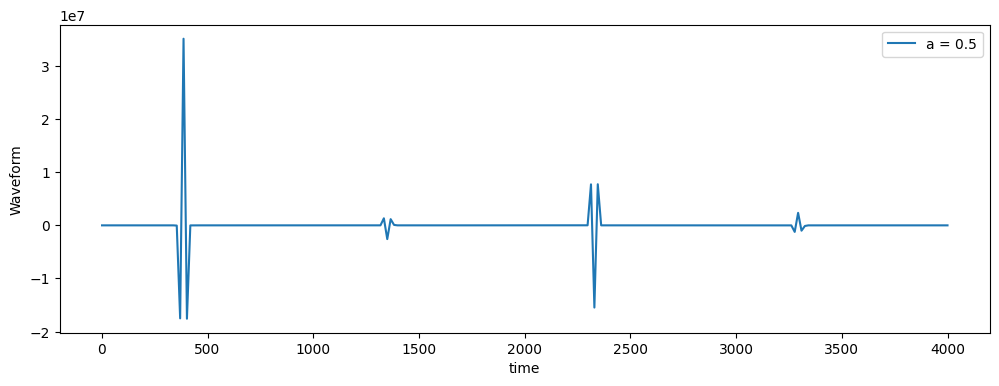

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for example in datasets["train"][1:]:
    plt.plot(example["tsteps"], example["true_waveform"], label=f'a = {example["model_params"][3]}')

plt.xlabel("time")
plt.ylabel("Waveform")
plt.legend()
plt.show()

# Train

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(NN.parameters(), lr=0.0005)

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

def loss_function(pred, true):
    return torch.mean(torch.abs(pred - true))  # MAE example

for epoch in range(200):
    NN.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        outputs = NN(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    # Evaluate on test set...
    # Append test_losses, train_metrics, test_metrics
    
    if show_plots and epoch % 10 == 0:
        # Plot training progress here
        pass


# Save & Plots

In [ ]:
torch.save(NN.state_dict(), os.path.join(solutions_dir, "model_chiphi.pth"))

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.savefig(os.path.join(output_dir, "plot_metrics.png"))
